# Custom DQN basic

## Import Library

In [1]:
import collections
# import gym
import numpy as np
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from typing import Any, List, Sequence, Tuple

## Make Custom Game
규칙. 
- 4 개의 구멍이 있다.<br>
- 구멍의 번호를 선택하면 그 구멍에 2개의 공이 들어간다.<br>
- 선택한 구멍의 양 옆의 구멍의 공의 갯수는 1/2 이 된다.<br>
- 한 구멍의 공의 갯수가 4개를 넘어가면 게임이 종료된다.

In [2]:
class virtual_game:
  pan = None        # 게임판
  hole_numbers = 0  # 구멍의 갯수
  hole_depth = 0    # 구멍의 깊이
  score = 0         # 스코어 계산에 사용하는 변수
  count = 0         # 해당 행동의 reward 를 반환하기 위한 함수
  done = False      # 게임의 종료 여부 판단
  path = None       # 게임 종료 후 Replay 를 위해 행동 저장

  def __init__( self, hole_numbers=4, hole_depth=4):
    self.hole_numbers = hole_numbers
    self.hole_depth = hole_depth
    self.reset()

  # 게임 초기화 함수
  def reset(self):
    self.pan = np.zeros(self.hole_numbers)
    self.path = []
    self.score = 0
    self.count = 0
    self.done = False
    return self.pan
  
  # 현재 스코어 반환 함수
  def scored(self):
    self.score = 0
    for i in self.pan:
      self.score = self.score + i
    return self.score

  # hole 의 번호를 입력받아 게임을 실행하는 함수
  # 게임판 정보와 count(reward)와 게임종료 여부를 반환
  def play(self, hole):
    #reward 초기화
    self.count = 0
    # hole 이 잘못 들어온 경우 변화없음.
    if (hole > self.hole_depth-1) or (hole < 0) :
      return self.pan , self.count, self.done, 
    
    # hole 이 제대로 들어왔을 시 게임 진행
    # replay 를 위한 path 저장
    self.path.append(hole)
    # hole 의 값 증가 시키기
    # reward 도 증가
    self.count = self.count +4
    self.pan[hole] = self.pan[hole] +2

    # hole 이 4보다 커진 경우 4로 고정시켜주고 게임종료
    if self.pan[hole] > 4 :
      # 게임이 종료되는 것 자체가 좋지 않다고 생각하여 패널티 부여
      # self.count = self.count -5
      self.pan[hole] = 4
      self.done = True
      # 만약에 판 전체의 score 가 10을 넘어갈 경우 reward 100 으로 고정
      if self.scored() > 10 :
        self.count = 100
      return self.pan , self.count, self.done, 
    # hole 양쪽의 공의 갯수 1/2 로 줄이기
    if (hole-1) >= 0 : # 왼쪽 홀이 있을 시
        self.count = self.count -1
        self.pan[hole-1] = round(self.pan[hole-1]/2 + 0.1)
    if (hole+1) <= 3 : # 오른쪽 홀이 있을 시
        self.count = self.count -1
        self.pan[hole+1] = round(self.pan[hole+1]/2 +0.1)

    return self.pan , self.count, self.done, 

### Game test

In [3]:
env = virtual_game()

In [4]:
env.reset()
actions = [0,2,1,3,0,0,0]
for i in actions :
  env.play(i)
  print('action = ',i)
  print(env.pan)
  if env.done :
    break;
print('================')
print(env.scored())
print(env.pan)

action =  0
[2. 0. 0. 0.]
action =  2
[2. 0. 2. 0.]
action =  1
[1. 2. 1. 0.]
action =  3
[1. 2. 1. 2.]
action =  0
[3. 1. 1. 2.]
action =  0
[4. 1. 1. 2.]
8.0
[4. 1. 1. 2.]


## Model 설계

In [5]:
env.pan.shape

(4,)

In [6]:
num_actions = env.hole_numbers

In [7]:
model = Sequential()
model.add(layers.InputLayer(batch_input_shape=(num_actions,1)))
model.add(layers.Dense(10, activation='sigmoid'))
model.add(layers.Dense(15, activation='sigmoid'))
model.add(layers.Dense(num_actions, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

## Model 훈련

In [8]:
num_episodes = 1000

In [9]:
# now execute the q learning
y = 0.95              # y
eps = 0.5             # epsilon
decay_factor = 0.999  # decay factor
r_avg_list = []       # reward 기록
for i in range(num_episodes):
    s = env.reset()   # reset game
    new_s = s
    eps *= decay_factor
    if i % 100 == 0:    # 100 번 훈련할 때마다 출력
        print("Episode {} of {}".format(i + 1, num_episodes))
    done = False
    r_sum = 0
    while not done:
        # 훈련 시작
        if np.random.random() < eps:
          # 랜덤으로 액션 
          a = np.random.randint(0, num_actions)
        else:
          # 모델 예측으로 액션
          a = np.argmax(model.predict(new_s))

        # 액션 값으로 게임 진행
        new_s, r, done = env.play(a)

        # target 설정
        target = r + y * np.argmax(model.predict(new_s))
        target_vec = model.predict(s)
        # 예측으로 나온 action 값이 홀의 갯수를 넘어갈 경우 넘어가지 않게 해줌.
        if a >= num_actions :
          a = a % num_actions
          
        target_vec[a] = target
        hist = model.fit(np.array(s), target_vec.reshape(num_actions,-1), epochs=1, verbose=0)
        s = new_s
        r_sum +=r
    print (s)
    print( r_sum)
    r_avg_list.append(r_sum / 1000)
    if r_sum > 90 :
      break

    

Episode 1 of 1000
[1. 4. 0. 0.]
11
[4. 1. 4. 1.]
38
[1. 1. 4. 1.]
16
[1. 4. 0. 4.]
19
[2. 4. 2. 2.]
31
[0. 4. 0. 2.]
11
[1. 2. 0. 4.]
15
[1. 4. 0. 0.]
11
[1. 4. 0. 0.]
13
[1. 4. 0. 0.]
11
[2. 1. 4. 2.]
26
[1. 3. 1. 4.]
23
[2. 4. 0. 0.]
18
[1. 4. 1. 2.]
16
[0. 4. 0. 0.]
8
[0. 4. 1. 0.]
10
[0. 4. 0. 2.]
11
[1. 3. 1. 4.]
26
[1. 4. 2. 1.]
20
[1. 2. 0. 4.]
15
[0. 4. 0. 2.]
11
[0. 3. 1. 4.]
21
[1. 4. 1. 2.]
18
[0. 4. 1. 0.]
12
[2. 2. 4. 2.]
24
[2. 2. 4. 1.]
23
[4. 2. 1. 3.]
25
[2. 3. 1. 4.]
26
[1. 4. 0. 2.]
16
[0. 4. 2. 1.]
15
[2. 4. 1. 2.]
24
[2. 4. 2. 0.]
29
[0. 4. 1. 0.]
10
[0. 4. 2. 1.]
20
[4. 2. 1. 0.]
16
[4. 2. 0. 4.]
20
[1. 4. 1. 4.]
19
[0. 4. 0. 2.]
11
[2. 4. 2. 2.]
28
[1. 4. 2. 1.]
20
[1. 4. 1. 2.]
18
[2. 1. 2. 4.]
22
[4. 1. 4. 2.]
122


No handles with labels found to put in legend.


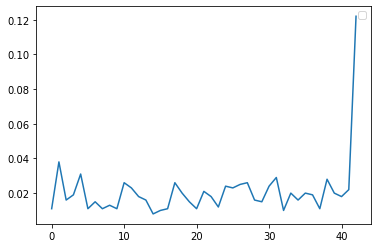

In [10]:
from matplotlib import pyplot
pyplot.plot(r_avg_list)
pyplot.legend()
pyplot.show()

In [11]:
print(r_avg_list)

[0.011, 0.038, 0.016, 0.019, 0.031, 0.011, 0.015, 0.011, 0.013, 0.011, 0.026, 0.023, 0.018, 0.016, 0.008, 0.01, 0.011, 0.026, 0.02, 0.015, 0.011, 0.021, 0.018, 0.012, 0.024, 0.023, 0.025, 0.026, 0.016, 0.015, 0.024, 0.029, 0.01, 0.02, 0.016, 0.02, 0.019, 0.011, 0.028, 0.02, 0.018, 0.022, 0.122]


In [12]:
bestpath = env.path
print(bestpath)

[1, 3, 0, 1, 2, 2, 0, 3, 2, 0]


In [13]:
env.reset()
for i in bestpath :
  env.play(i)
  print('action = ',i)
  print(env.pan)
  if env.done :
    break;
print('================')
print(env.scored())
print(env.pan)

action =  1
[0. 2. 0. 0.]
action =  3
[0. 2. 0. 2.]
action =  0
[2. 1. 0. 2.]
action =  1
[1. 3. 0. 2.]
action =  2
[1. 2. 2. 1.]
action =  2
[1. 1. 4. 1.]
action =  0
[3. 1. 4. 1.]
action =  3
[3. 1. 2. 3.]
action =  2
[3. 1. 4. 2.]
action =  0
[4. 1. 4. 2.]
11.0
[4. 1. 4. 2.]
